In [1]:
# Generate MNIST digits
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt



In [2]:
# Load and preprocess data
(x_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_train = x_train.reshape(-1, 28*28)  # Flatten images

BUFFER_SIZE = 60000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)



11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [3]:
# --------------------------# Define the generator
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, use_bias=False, input_shape=(100,)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(512, use_bias=False))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(1024, use_bias=False))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(28*28, activation='tanh'))
    return model



In [4]:
# --------------------------
# Define the discriminator
# --------------------------
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(1024, input_shape=(28*28,)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model



In [5]:
# --------------------------
# Loss and optimizers
# --------------------------
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator = make_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)



C:\Users\himan\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
# --------------------------
# Training loop
# --------------------------
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16



In [20]:
# Fixed seed for visualization
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    


In [21]:
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)
        
        print(f'Epoch {epoch+1} completed')
        generate_and_save_images(generator, epoch + 1, seed)



In [22]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    predictions = (predictions + 1) / 2.0  # scale from [-1,1] to [0,1]
    
    # Convert tensor to numpy array
    predictions = predictions.numpy()
    
    fig = plt.figure(figsize=(4,4))
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i].reshape(28,28), cmap='gray')
        plt.axis('off')
    
    plt.suptitle(f'Epoch {epoch}')
    plt.show()


Epoch 1 completed


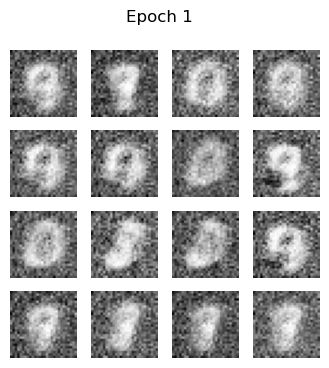

Epoch 2 completed


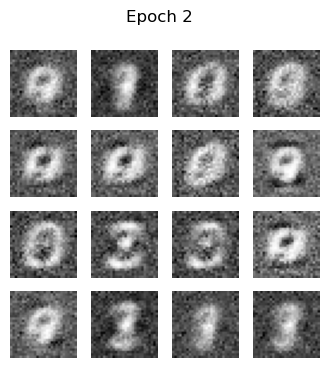

Epoch 3 completed


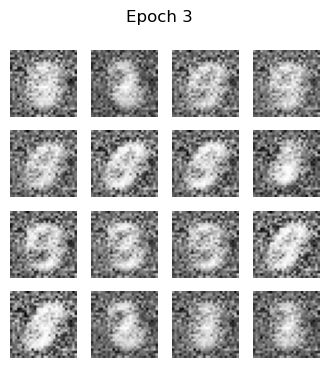

In [ ]:
# --------------------------
# Start training
# --------------------------
train(train_dataset, EPOCHS)
